# Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [228]:
# Load pickled data
import pickle
# import numpy as np

# Read in data for training, validation and testing
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height of the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [229]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the Data Set

In [230]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np

# Visualizations will be shown in the notebook
%matplotlib inline

signs = {}

import csv
with open('signnames.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if row[0] == 'ClassId': 
            pass
        else:
            signs[int(row[0])] = row[1]

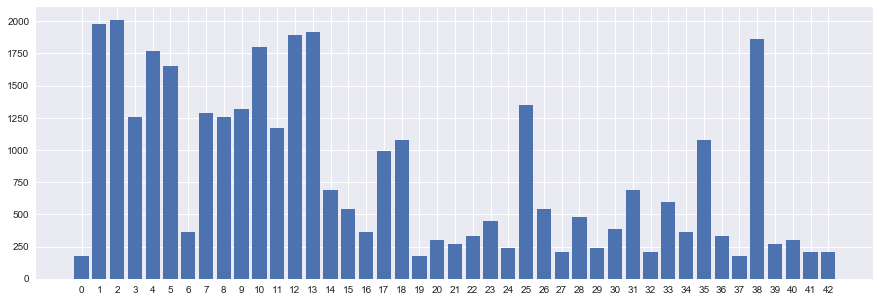

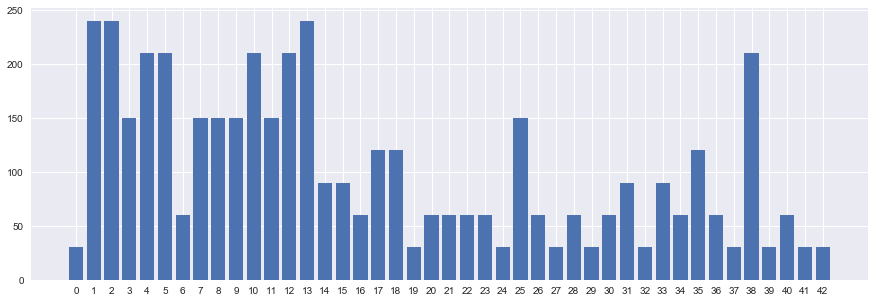

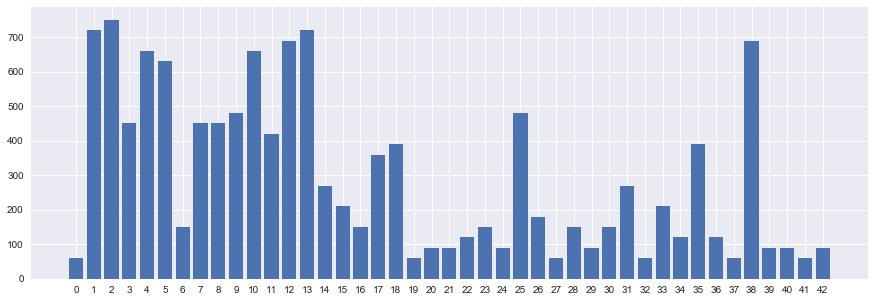

In [231]:
hist_train = []
hist_valid = []
hist_test = []

for key in signs.keys():
    hist_train.append((y_train == key).sum())
    hist_valid.append((y_valid == key).sum())
    hist_test.append((y_test == key).sum())

# Training data
plt.figure(figsize=(15,5))
plt.bar(signs.keys(), hist_train)
plt.xticks(np.arange(0, n_classes, step=1))
# plt.bar(signs.values(), hist_train)
# plt.xticks(np.arange(0, n_classes, step=1), rotation='vertical')
plt.grid(True)
plt.savefig("examples/training_data.jpg")
plt.show()

# Validation data
plt.figure(figsize=(15,5))
plt.bar(signs.keys(), hist_valid)
plt.xticks(np.arange(0, n_classes, step=1))
plt.grid(True)
plt.savefig("examples/validation_data.jpg")
plt.show()

# Test data
plt.figure(figsize=(15,5))
plt.bar(signs.keys(), hist_test)
plt.xticks(np.arange(0, n_classes, step=1))
plt.grid(True)
plt.savefig("examples/test_data.jpg")
plt.show()

In [232]:
def get_index_by_label(label, y):
    for index in range(len(y)):
        if y[index] == label:
            return index
    return 0

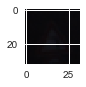

In [233]:
# index = random.randint(0, len(X_train))
index = get_index_by_label(19, y_train)
image = X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")

# plt.style.use('seaborn') # pretty matplotlib plots
# plt.rcParams['figure.figsize'] = (12, 8)

----

## Step 2: Design and Test Model Architecture

The architecture for the model used is derived from the LeNet-5 architecture.

### Preprocess the Data Set

The data is normalized using `X_norm = (X - 128)/ 128`.

In [234]:
# Normalize - only execute once!
X_train = (X_train - 128.0) / 128
X_valid = (X_valid - 128.0) / 128
X_test = (X_test - 128.0) / 128

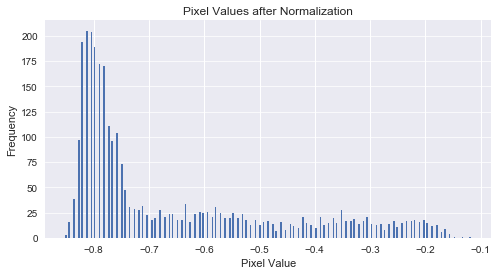

In [235]:
# Plot distribution of pixel values of normalized
image = X_train[0]
image = image.flatten()

plt.figure(figsize=(8,4))
n, bins, patches = plt.hist(image, bins=255)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Values after Normalization')
plt.savefig("examples/normalization.jpg")

### Model Architecture

In [236]:
import tensorflow as tf

### HYPERPARAMETERS
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.0014

DROPOUT_PROB = 0.5  # Dropout probability to keep units

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

In [237]:
from tensorflow.contrib.layers import flatten

conv1 = None
conv2 = None
fc3 = None
fc4 = None
fc5 = None

def LeNet(x):   
    global conv1
    global conv2
    global fc3
    global fc4
    global fc5
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
    # The shape of the filter weight is (height, width, input_depth, output_depth) 
    wc1    = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 12), mean=mu, stddev=sigma))
    bc1    = tf.Variable(tf.zeros(12))
    conv1  = tf.nn.conv2d(x, wc1, strides=[1, 1, 1, 1], padding='VALID') + bc1

    # Activation.
    conv1  = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1  = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x32.
    wc2    = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean=mu, stddev=sigma))
    bc2    = tf.Variable(tf.zeros(32))
    conv2  = tf.nn.conv2d(conv1, wc2, strides=[1, 1, 1, 1], padding='VALID') + bc2
    
    # Activation.
    conv2  = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x32.
    conv2  = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 800.
    fc3    = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    wd3    = tf.Variable(tf.truncated_normal(shape=(800, 120), mean=mu, stddev=sigma))
    bd3    = tf.Variable(tf.zeros(120))
    fc3    = tf.matmul(fc3, wd3) + bd3
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Dropout.
    fc3    = tf.nn.dropout(fc3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    wd4    = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    bd4    = tf.Variable(tf.zeros(84))
    fc4    = tf.matmul(fc3, wd4) + bd4
    
    # Activation.
    fc4    = tf.nn.relu(fc4)
    
    # Dropout.
    fc4    = tf.nn.dropout(fc4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    wd5    = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    bd5    = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc4, wd5) + bd5
    
    return logits

### Train, Validate and Test the Model

In [238]:
# Define batch variables
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# One-hot encoding
one_hot_y = tf.one_hot(y, n_classes)

In [239]:
# Training pipeline
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# tf.reduce_mean computes the mean of elements across dimensions of a tensor
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [240]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_valid, y_valid):
    # Use this to accumulate accuracy values across batches
    total_accuracy = 0
    
    n_valid = len(y_valid)
    
    sess = tf.get_default_session()
    
    # Create batches: offset = 0, BATCH_SIZE, 2*BATCH_SIZE, ... from validation training data X_valid
    for offset in range(0, n_valid, BATCH_SIZE):
        batch_x, batch_y = X_valid[offset:offset+BATCH_SIZE], y_valid[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / n_valid

In [241]:
from sklearn.utils import shuffle

# Model training
# Use an interactive session so that output_feature_map can access the session variables 
sess = tf.InteractiveSession()
sess.as_default()
sess.run(tf.global_variables_initializer())

# Save numbers for plotting some statistics
validation_accuracy = []
training_accuracy = []

print("Training...")
print()

for i in range(EPOCHS):
    # Shuffle training data
    X_train, y_train = shuffle(X_train, y_train)
    
    # Create batches: offset = 0, BATCH_SIZE, 2*BATCH_SIZE, ... from normalized training data X_train
    for offset in range(0, n_train, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_train[offset:end], y_train[offset:end]
        
        # Train the model using the batches
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT_PROB})

    # Model evaluation using validation data
    validation_accuracy.append(evaluate(X_valid, y_valid))
    training_accuracy.append(evaluate(X_train, y_train))
    
    # Print statistics
    print("EPOCH {} ...".format(i + 1))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
    print("Training Accuracy = {:.3f}".format(training_accuracy[i]))
    print()

saver.save(sess, './lenet')
print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.725
Training Accuracy = 0.782

EPOCH 2 ...
Validation Accuracy = 0.833
Training Accuracy = 0.901

EPOCH 3 ...
Validation Accuracy = 0.905
Training Accuracy = 0.957

EPOCH 4 ...
Validation Accuracy = 0.917
Training Accuracy = 0.967

EPOCH 5 ...
Validation Accuracy = 0.929
Training Accuracy = 0.979

EPOCH 6 ...
Validation Accuracy = 0.947
Training Accuracy = 0.985

EPOCH 7 ...
Validation Accuracy = 0.939
Training Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.953
Training Accuracy = 0.992

EPOCH 9 ...
Validation Accuracy = 0.955
Training Accuracy = 0.991

EPOCH 10 ...
Validation Accuracy = 0.949
Training Accuracy = 0.992

Model saved


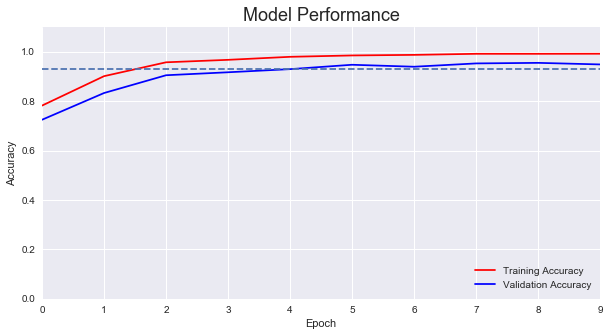

In [242]:
# Show some statistics

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (10, 5)

figure = plt.subplot(1,1,1)
figure.set_title("Model Performance", fontsize=18)
figure.plot(range(len(training_accuracy)), training_accuracy, 'r', label='Training Accuracy')
figure.plot(range(len(training_accuracy)), validation_accuracy, 'b', label='Validation Accuracy')
figure.plot(range(len(training_accuracy)), [0.93]*10, '--')
figure.set_ylim([0, 1.1])
figure.set_xlim([0, 9])
figure.set_ylabel("Accuracy")
figure.set_xlabel("Epoch")
figure.legend(loc=4)

plt.show()

In [243]:
# Test the model on test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.939


---

## Step 3: Test a Model on New Images

The performance of the model is tested on images showing German traffic signs that were downloaded from the web.

### Load and Output the Images

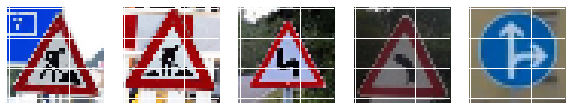

In [244]:
### Load and plot images

import cv2
import glob
import matplotlib.image as mpimg

# Make a list of the images
images = glob.glob('signs/sign*.jpg')

X_test_own = np.ndarray(shape=(len(images),32,32,3), dtype=int)
y_test_own = np.ndarray((len(images),), dtype=int)

# Manually label images
y_test_own[0] = 25
y_test_own[1] = 25
y_test_own[2] = 21
y_test_own[3] = 19
y_test_own[4] = 36

f, axes = plt.subplots(1, len(images), figsize=(10,10))

for idx, fname in enumerate(sorted(images)):
    image = mpimg.imread(fname)
    image = cv2.resize(image, dsize=(32, 32))
    X_test_own[idx] = image
    axes[idx].imshow(X_test_own[idx])
    axes[idx].tick_params(bottom=False, left=False)
    axes[idx].set_yticklabels([])
    axes[idx].set_xticklabels([])

# Normalize
X_test_own = (X_test_own - 128.0) / 128

### Predict the Sign Type for Each Image

In [245]:
### Run predictions and use model to output prediction for each image

prediction_operation = tf.nn.softmax(logits)

prediction = None

sess = tf.InteractiveSession()
sess.as_default()

saver.restore(sess, tf.train.latest_checkpoint('.'))
prediction = sess.run(prediction_operation, feed_dict={x: X_test_own, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./lenet


In [246]:
max_prediction = [np.argmax(prediction[i]) for i in range(len(prediction))]

print("Predictions: ", max_prediction)

Predictions:  [25, 21, 21, 19, 36]


### Analyze Performance

In [247]:
### Calculate accuracy for new images
accuracy = 0

accuracy = sess.run(accuracy_operation, feed_dict={x: X_test_own, y: y_test_own, keep_prob: 1.0})
    
print("Accuracy for new images = {:.3f}".format(accuracy))

Accuracy for new images = 0.800


### Output Top 5 Softmax Probabilities For Each Image

For each of the new images, the top 5 softmax probabilities are printed to show the **certainty** of the predictions as made by the model.

In [248]:
### Print out top five softmax probabilities for predictions on German traffic sign images found on the web

probabilities = sess.run(tf.nn.top_k(tf.constant(prediction), k=5))

for i in range(len(images)):
    print("Top 5 probabilities for image #{}: ".format(i + 1))
    for j in range(len(images)):
        print("{:.5f} ".format(probabilities[0][i][j]), signs[probabilities[1][i][j]])
    print()
    print()

Top 5 probabilities for image #1: 
1.00000  Road work
0.00000  Dangerous curve to the right
0.00000  Bumpy road
0.00000  Bicycles crossing
0.00000  Beware of ice/snow


Top 5 probabilities for image #2: 
0.63891  Double curve
0.32089  Road work
0.03589  Beware of ice/snow
0.00235  Wild animals crossing
0.00184  Right-of-way at the next intersection


Top 5 probabilities for image #3: 
0.99546  Double curve
0.00454  Wild animals crossing
0.00000  Dangerous curve to the left
0.00000  Slippery road
0.00000  Road work


Top 5 probabilities for image #4: 
0.99013  Dangerous curve to the left
0.00707  Double curve
0.00276  Slippery road
0.00004  Wild animals crossing
0.00000  No passing


Top 5 probabilities for image #5: 
0.99999  Go straight or right
0.00001  Keep right
0.00000  Turn left ahead
0.00000  Keep left
0.00000  Turn right ahead




---

## Step 4: Visualize the Neural Network's State with Test Images

The following code based on [this post](https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4). It visualizes the hidden layers of the Neural Network.

In [249]:
import math

def get_activations(layer, stimuli):
    units = sess.run(layer, feed_dict={x: np.reshape(stimuli, (1, 32, 32, 3)), keep_prob: 1.0})
    plot_filter(units)
    
def plot_filter(units):
    filters = units.shape[3]
    # plt.figure(1, figsize=(20,10))
    plt.figure(1)
    
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

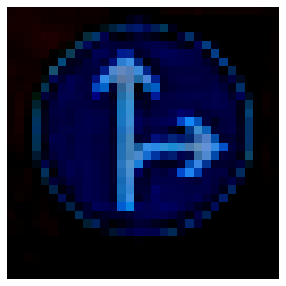

In [250]:
test_image = X_test_own[4]
plt.imshow(test_image)
plt.xticks([])
plt.yticks([])

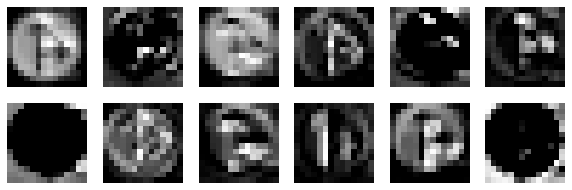

In [251]:
# Plot first convolutional layer
get_activations(conv1, test_image)

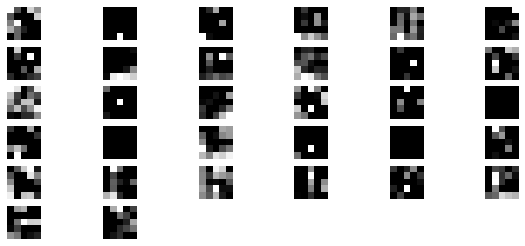

In [252]:
# Plot second convolutional layer
get_activations(conv2, test_image)